[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tailvar/theAIE/blob/master/aiecode/ch02/notebooks/tae_capstone_wk2.ipynb)

In [55]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Install PyTorch (Colab usually has numpy/matplotlib already)
    !pip install --quiet torch torchvision


In [ ]:
# Tiny One-Hidden-Layer MLP: NumPy → PyTorch (XOR) 

---

This notebook builds a complete end-to-end workflow for understanding how a tiny feed-forward neural network learns a nonlinear classification task. The emphasis is on understanding the mathematics by implementating a gradient descent neural network model first manually and then progressively through PyTorch implementations — while keeping the dataset, seeds, and architecture consistent.

### Training Step Overview

Every iteration of neural-network training follows the same computational pipeline:

1. **`zero_grad()`**  
   Clears any gradients left over from the previous step.  
   (PyTorch accumulates gradients by default, so clearing them is essential.)

2. **Forward pass**  
   Inputs flow through the network to produce predictions using the current parameters:  
   
        x ──> fθ(x)


3. **Loss computation**  
   Measures how far the prediction is from the target:
    
       L = loss(fθ(x), y)


4. **Backward pass**  
   Applies the chain rule to compute gradients of the loss with respect to all parameters:  
   
       ∇θ L
           

5. **Parameter update (`step()`)**  
   The optimiser uses these gradients to tweak the parameters slightly:  
   
        θ ← θ − η · ∇θ L


Together, these operations form the core **learning loop** in both the NumPy and PyTorch implementations of the MLP.

    [ zero_grad ] ──▶ [ forward ] ──▶ [ loss ] ──▶ [ backward ] ──▶ [ step ]

---

### **1. Manual NumPy MLP (gaining an intuition behind the matsh)**  
- Implement forward pass: affine → ReLU → affine → scalar output.  
- Implement backward pass explicitly using the chain rule.  
- Train with full-batch gradient descent and confirm the network can learn XOR.  
- Observe convergence, accuracy, and behaviour such as potential dead ReLUs.

---

### **2. PyTorch (forward only)**  
- Reproduce the same computation graph using PyTorch tensors **without autograd**.  
- Verify that the PyTorch forward loss matches the NumPy loss (up to numerical precision).  

---

### **3. PyTorch autograd (gradient equivalence test)**  
- Enable `requires_grad=True` for parameters.  
- Run `forward()` + `.backward()`.  
- Compare PyTorch gradients with **manual NumPy gradients on the same fixed batch**.  
- Confirm correctness to within ~1e-6 to 1e-4.

---

### **4. Further train models using PyTorch**  
Two equivalent implementations trained with SGD:

- **`nn.Module` custom TinyMLP**, with explicit parameters `W1`, `b1`, `W2`, `b2` (matching the NumPy shapes).  
- **`nn.Sequential`**, an equivalent 3-layer network using built-in `nn.Linear` + `nn.ReLU`.

Both achieve similar performance and decision boundaries.

---

### **5. Diagnostics & visualisations**  
- Plot training curves: **loss**, **gradient norms**, **ReLU activation fraction**, **accuracy**.  
- Plot **decision boundaries** for all three implementations:  
  - NumPy manual MLP  
  - PyTorch `TinyMLP`  
  - PyTorch `nn.Sequential`  
- Compare how each implementation bends the input space and separates XOR.

---

<b><u><span style="font-size:18px">Import packages, create Configs, set seeds</span></u></b>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

# Global configs
D = 2          # input dimension
H = 16         # hidden units
N_TRAIN = 200  # number of training samples

SEED_DATA = 0
SEED_PARAMS = 1
DEVICE = "cpu"


def set_seeds(seed: int = 0) -> None:
    """Set NumPy and Torch seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)


set_seeds(0)

print("Config:")
print(f"D={D}, H={H}, N_TRAIN={N_TRAIN}, DEVICE={DEVICE}")


Config:
D=2, H=16, N_TRAIN=200, DEVICE=cpu


<b><u><span style="font-size:18px">Generate data for the notebook</span></u></b>

In [4]:
def make_xor_data(n_samples=N_TRAIN, seed=SEED_DATA):
    """
    XOR-like dataset in R^2:
    - sample points (x1, x2) uniformly from [-1, 1] x [-1, 1]
    - label y = 1 if x1 * x2 < 0 (top-left or bottom-right), else 0.
    """
    rng = np.random.default_rng(seed)
    X = rng.uniform(-1.0, 1.0, size=(n_samples, 2))
    y = (X[:, 0] * X[:, 1] < 0).astype(float)
    return X, y


X_train_np, y_train_np = make_xor_data()
print("Training data shapes:", X_train_np.shape, y_train_np.shape)


Training data shapes: (200, 2) (200,)


<b><u><span style="font-size:18px">Create NumPy helpers: ReLU + forward/backward (single + batch)</span></u></b>

In [42]:
def relu_np(u: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, u)

def relu_prime_np(u: np.ndarray) -> np.ndarray:
    """Derivative of ReLU: 1 where u > 0, else 0."""
    return (u > 0).astype(float)

def numpy_forward_single(x, y, W1, b1, W2, b2):
    """
    Forward pass for a single sample x (shape (D,)).

    Returns: (L, f, a1, h1)
      L  : scalar loss
      f  : scalar network output
      a1 : (H,) pre-activation
      h1 : (H,) hidden activations (ReLU(a1))
    """
    # W1 @ x is matrix vector multiply
    # (h, d) @ (d,) -> (h,)
    # b1 (shape (h,) is added elementwise
    # result a1 is the pre-activation of thehidden layer
    a1 = W1 @ x + b1            # (H,)
    
    # apply ReLU elementwise h1[i] = max(0, a1[i]) -> shape (h,)
    # this is the hidden activation
    h1 = relu_np(a1)            # (H,)
    
    # W2 has the shape (1,h), h1 is (h,) -> (1,)
    # add scalar b2, the result is a 1D array with 1 element
    f = (W2 @ h1 + b2).item()   # (1,) -> scalar
    
    # L = scalar sqaured error loss (1/2 makes derivative "nicer")
    L = 0.5 * (f - y) ** 2
    
    return L, f, a1, h1


def numpy_backward_single(x, y, W1, b1, W2, b2, f, a1, h1):
    """
    Backward pass for a single sample.

    Returns gradients: dW1, db1, dW2, db2 with shapes:
      dW1: (H, D)
      db1: (H,)
      dW2: (1, H)
      db2: scalar
    """
    # ----- output layer -----
    df = (f - y)                      # scalar, dL/df

    # h1 has shape (h,), h1[None, :] makes it shape (1, h)
    # df is a scalar so the result shape -> (1, h) the same as W2
    # thisis the gradient
    dW2 = df * h1[None, :]            # (1, H)

    # Bias b2 just shifts theoutput, its gradient is the same as df
    db2 = df                          # scalar

    """----- backprop -----"""
    # W2.T has shape (h,1); multiply it by scalar 
    # df -> (h,1) then we flatten.
    # This is how the error "flows back" from the output into the
    # hidden layer
    dh1 = (W2.T * df).reshape(-1)     # (H,)

    # relu's derivative relu_prime(a1) is 1 where a1 > 0 else its 0.
    # d1 and relu_prime are both of shape (h,) we multiply elementwise
    da1 = dh1 * relu_prime_np(a1)     # (H,)

    # ----- first layer -----
    # da1[:, None] turns (h,) into (h,1)
    # X{None,:] turns (d,) into (1,d)
    # matrix multiple -> (h, d) -> the shape shape as W1
    dW1 = da1[:, None] @ x[None, :]   # (H, D)

    # bias b1 only adds to a1 so its gradient ܷis δa1  
    db1 = da1                         # (H,)

    return dW1, db1, dW2, db2


def numpy_forward_backward_batch(X, y, W1, b1, W2, b2):
    """
    Manual NumPy forward+backward for a batch.
    Returns: mean batch loss, mean (dW1, db1, dW2, db2) over the batch.
    """
    N = X.shape[0]

    dW1 = np.zeros_like(W1)
    db1 = np.zeros_like(b1)
    dW2 = np.zeros_like(W2)
    db2 = 0.0
    total_loss = 0.0

    for i in range(N):
        x_i = X[i]
        y_i = y[i]
        L_i, f_i, a1_i, h1_i = numpy_forward_single(
            x_i, y_i, W1, b1, W2, b2
        )
        total_loss += L_i

        gW1_i, gb1_i, gW2_i, gb2_i = numpy_backward_single(
            x_i, y_i, W1, b1, W2, b2, f_i, a1_i, h1_i
        )
        dW1 += gW1_i
        db1 += gb1_i
        dW2 += gW2_i
        db2 += gb2_i

    L_mean = total_loss / N
    dW1 /= N
    db1 /= N
    dW2 /= N
    db2 /= N

    return L_mean, dW1, db1, dW2, db2

# Convert shape objects to tuples (NumPy and PyTorch)
def shape(x):
    return tuple(x.shape)

def check_param_shapes(W1, b1, W2, b2, D, H):
    """
    Verify that the parameters have the correct shapes:

        W1: (H, D)
        b1: (H,)
        W2: (1, H)
        b2: scalar (shape (,) or (1,))

    Accepts NumPy arrays or PyTorch tensors.
    Raises ValueError with a helpful message if anything is mismatched.
    """

    def shape(x):
        # NumPy array
        if isinstance(x, np.ndarray):
            return tuple(x.shape)
        # PyTorch tensor
        if torch.is_tensor(x):
            return tuple(x.shape)
        # Python / NumPy scalar (float, int, np scalar)
        if np.isscalar(x) or isinstance(x, (float, int)):
            return ()   # scalar shape
        # Anything else
        raise TypeError(f"Unsupported type for shape(): {type(x)}")

    expected = {
        "W1": (H, D),
        "b1": (H,),
        "W2": (1, H),
        "b2": (),      # scalar: shape () in both NumPy and torch
    }

    actual = {
        "W1": shape(W1),
        "b1": shape(b1),
        "W2": shape(W2),
        "b2": shape(b2),
    }

    errors = []
    for name in expected:
        if expected[name] != actual[name]:
            errors.append(
                f"{name}: expected {expected[name]}, got {actual[name]}"
            )

    if errors:
        raise ValueError(
            "Parameter shape mismatch:\n  " + "\n  ".join(errors)
        )

    print("Parameter shapes OK:")
    for name in expected:
        print(f"  {name}: {actual[name]}")
    


print("NumPy helper functions ccreated.")


NumPy helper functions ccreated.


<b><u><span style="font-size:18px">NumPy Parameter init and shape check</span></u></b>

In [43]:
def init_params_numpy(d: int, h: int, seed: int = SEED_PARAMS):
    """
    Initialise parameters for NumPy MLP:
      W1: (H, D), b1: (H,)
      W2: (1, H), b2: scalar
    """
    rng = np.random.default_rng(seed)
    W1 = rng.normal(0.0, 0.5, size=(h, d))
    b1 = np.zeros(h)
    W2 = rng.normal(0.0, 0.5, size=(1, h))
    b2 = np.array(0.0)
    return W1, b1, W2, b2


def check_param_shapes(W1, b1, W2, b2, d: int, h: int):
    assert W1.shape == (h, d), f"W1 shape {W1.shape}, expected {(h, d)}"
    assert b1.shape == (h,), f"b1 shape {b1.shape}, expected {(h,)}"
    assert W2.shape == (1, h), f"W2 shape {W2.shape}, expected {(1, h)}"
    assert np.isscalar(b2) or b2.shape == (), "b2 should be scalar-like"
    print("Parameter shapes OK:",
          f"W1 {W1.shape}, b1 {b1.shape}, W2 {W2.shape}, b2 scalar")


# Quick check
W1_np, b1_np, W2_np, b2_np = init_params_numpy(D, H, seed=SEED_PARAMS)
check_param_shapes(W1_np, b1_np, W2_np, b2_np, D, H)


Parameter shapes OK: W1 (16, 2), b1 (16,), W2 (1, 16), b2 scalar


<b><u><span style="font-size:18px">NumPy training loop</span></u></b>

In [44]:
def train_numpy(X, y, d, h, lr=0.1, n_epochs=1000, seed=SEED_PARAMS):
    """
    Full-batch gradient descent on XOR using manual NumPy forward/backward.
    """
    W1, b1, W2, b2 = init_params_numpy(d, h, seed=seed)
    N = X.shape[0]

    loss_history = []
    acc_history = []

    for epoch in range(n_epochs):
        # Forward+backward over whole batch
        L, dW1, db1, dW2, db2 = numpy_forward_backward_batch(
            X, y, W1, b1, W2, b2
        )

        # Compute predictions for accuracy
        preds = []
        for i in range(N):
            _, f_i, _, _ = numpy_forward_single(X[i], y[i], W1, b1, W2, b2)
            preds.append(1.0 if f_i >= 0.5 else 0.0)
        preds = np.array(preds)
        acc = (preds == y).mean()

        # Gradient step
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

        loss_history.append(L)
        acc_history.append(acc)

        if (epoch + 1) % 100 == 0:
            print(f"[NumPy] Epoch {epoch+1:4d} | loss={L:.4f} | acc={acc:.3f}")

    params = (W1, b1, W2, b2)
    return params, loss_history, acc_history


params_np, loss_history_np, acc_history_np = train_numpy(
    X_train_np, y_train_np, D, H, lr=0.1, n_epochs=1000, seed=SEED_PARAMS
)

print("Final NumPy loss:", loss_history_np[-1])
print("Final NumPy accuracy:", acc_history_np[-1])


[NumPy] Epoch  100 | loss=0.0446 | acc=0.960
[NumPy] Epoch  200 | loss=0.0399 | acc=0.970
[NumPy] Epoch  300 | loss=0.0377 | acc=0.975
[NumPy] Epoch  400 | loss=0.0363 | acc=0.975
[NumPy] Epoch  500 | loss=0.0351 | acc=0.975
[NumPy] Epoch  600 | loss=0.0341 | acc=0.980
[NumPy] Epoch  700 | loss=0.0334 | acc=0.980
[NumPy] Epoch  800 | loss=0.0326 | acc=0.980
[NumPy] Epoch  900 | loss=0.0320 | acc=0.980
[NumPy] Epoch 1000 | loss=0.0313 | acc=0.980
Final NumPy loss: 0.031325756731886485
Final NumPy accuracy: 0.98


### Observations from the NumPy implementation

Parameter shapes matche the intended architecture: a 2D input, an 16-unit hidden layer, and a single scalar output.


**Training behaviour (NumPy + vanilla ReLU)**

Over 1,000 epochs, the training dynamics are stable and predictable.Loss falls steadily from the initial random state and converges to approximately **0.031**. Final training accuracy reaches **98%**. The training curve is smooth, consistent with full-batch gradient descent.

**Notes warn of dead ReLU's**

ReLU networks can suffer from dead units, hidden units whose pre-activations never rise above zero for any training sample. Dead units have output = 0, gradient = 0 and therefore never update. In small networks this matters because it reduces the effective capacity. In this model the hidden layer has 16 units which means that even if a subset becomes inactive, the remaining units still provide enough nonlinearity to solve the XOR problem well. The final loss (~0.031) suggests that most units remain active during training.

**Summary**

The NumPy implementation is consistent, converges well, and demonstrates the expected behaviour of a small ReLU network trained with full-batch gradient descent. Minor performance limits arise from network size and occasional dead ReLUs, but the model still reaches **98%** accuracy, validating both the math and the implementation.

<b><u><span style="font-size:18px">Gradient check: Numpy vs Torch autograd</span></u></b>

In [45]:
def gradient_check(X_np, y_np, d, h, seed=SEED_PARAMS, device=DEVICE):
    """
    Compare manual NumPy gradients to PyTorch autograd for a small batch.
    """
    # Shared params
    W1_np, b1_np, W2_np, b2_np = init_params_numpy(d, h, seed=seed)

    # NumPy reference loss + grads
    L_np, dW1_np, db1_np, dW2_np, db2_np = numpy_forward_backward_batch(
        X_np, y_np, W1_np, b1_np, W2_np, b2_np
    )

    # Torch tensors with autograd
    X_t = torch.tensor(X_np, dtype=torch.float32, device=device)
    y_t = torch.tensor(y_np, dtype=torch.float32, device=device)

    W1 = torch.tensor(W1_np, dtype=torch.float32, device=device, requires_grad=True)
    b1 = torch.tensor(b1_np, dtype=torch.float32, device=device, requires_grad=True)
    W2 = torch.tensor(W2_np, dtype=torch.float32, device=device, requires_grad=True)
    b2 = torch.tensor(b2_np, dtype=torch.float32, device=device, requires_grad=True)

    # Forward in Torch
    A1 = X_t @ W1.T + b1           # (N, H)
    H1 = torch.relu(A1)            # (N, H)
    F = (H1 @ W2.T + b2).squeeze(-1)  # (N,)
    loss = 0.5 * (F - y_t) ** 2
    loss = loss.mean()
    loss.backward()

    dW1_t = W1.grad.detach().cpu().numpy()
    db1_t = b1.grad.detach().cpu().numpy()
    dW2_t = W2.grad.detach().cpu().numpy()
    db2_t = b2.grad.detach().cpu().numpy()

    def max_abs_diff(a, b):
        return np.max(np.abs(a - b))

    print("NumPy loss:", L_np)
    print("Torch loss:", loss.item())
    print("Max |dW1_t - dW1_np|:", max_abs_diff(dW1_t, dW1_np))
    print("Max |db1_t - db1_np|:", max_abs_diff(db1_t, db1_np))
    print("Max |dW2_t - dW2_np|:", max_abs_diff(dW2_t, dW2_np))
    print("    |db2_t - db2_np|:", max_abs_diff(db2_t, db2_np))
    print("These should be very small (~1e-6 to 1e-4).")


# Use first 8 samples from the single training set
gradient_check(X_train_np[:8], y_train_np[:8], D, H)


NumPy loss: 0.163537103249268
Torch loss: 0.16353711485862732
Max |dW1_t - dW1_np|: 1.698428700458443e-08
Max |db1_t - db1_np|: 2.7644966593687315e-08
Max |dW2_t - dW2_np|: 3.857869074197495e-08
    |db2_t - db2_np|: 4.860311519916394e-08
These should be very small (~1e-6 to 1e-4).


**Gradient check summary**
The PyTorch autograd implementation matches the manual NumPy gradients to extremely high precision. The losses agree to machine-level floating-point accuracy, and the maximum absolute difference across all parameter gradients is on the order of 1e-8, far smaller than the typical tolerance range (1e-6 to 1e-4). This confirms that the NumPy backward pass is mathematically correct and that the PyTorch model reproduces it exactly.

<b><u><span style="font-size:18px">TinyMLP nn.Module (mirror NumPy math)</span></u></b>

In [46]:
class TinyMLP(nn.Module):
    """
    One hidden layer network mirroring the NumPy math:

        A1 = X @ W1^T + b1
        H1 = ReLU(A1)
        F  = H1 @ W2^T + b2
    """
    def __init__(self, d: int, h: int):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(h, d) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(h))
        self.W2 = nn.Parameter(torch.randn(1, h) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(()))

    def forward(self, X):
        # X: (N, D)
        A1 = X @ self.W1.T + self.b1    # (N, H)
        H1 = torch.relu(A1)             # (N, H)
        F = H1 @ self.W2.T + self.b2    # (N, 1)
        return F.squeeze(-1), A1, H1    # return pre-activations for diagnostics


print("TinyMLP class defined.")


TinyMLP class defined.


<b><u><span style="font-size:18px">Train TinyMLP and collect diagnostics</span></u></b>

In [47]:
# Convert full training data once
X_train_t = torch.tensor(X_train_np, dtype=torch.float32, device=DEVICE)
y_train_t = torch.tensor(y_train_np, dtype=torch.float32, device=DEVICE)

set_seeds(SEED_PARAMS)
tiny_mlp = TinyMLP(d=D, h=H).to(DEVICE)
optimizer = torch.optim.SGD(tiny_mlp.parameters(), lr=0.1)
n_epochs = 1000

losses = []
grad_norms = []
relu_activity = []
accuracies = []


for epoch in range(n_epochs):
    tiny_mlp.train()
    optimizer.zero_grad()

    F, A1, H1 = tiny_mlp(X_train_t)      # F: (N,), A1: (N, H)
    loss = 0.5 * (F - y_train_t) ** 2
    loss = loss.mean()

    loss.backward()

    # Diagnostics
    with torch.no_grad():
        # Gradient norm across all parameters
        total_sq = 0.0
        for p in tiny_mlp.parameters():
            if p.grad is not None:
                total_sq += (p.grad ** 2).sum().item()
        grad_norm = float(np.sqrt(total_sq))

        # ReLU activity: fraction of pre-activations > 0
        frac_active = (A1 > 0).float().mean().item()

        # Accuracy
        y_pred = (F >= 0.5).float()
        acc = (y_pred == y_train_t).float().mean().item()

    losses.append(loss.item())
    grad_norms.append(grad_norm)
    relu_activity.append(frac_active)
    accuracies.append(acc)

    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(
            f"[TinyMLP] Epoch={epoch+1:03d} | "
            f"loss={loss.item():.4f} | "
            f"acc={acc:.3f} | "
            f"grad_norm={grad_norm:.3f} | "
            f"ReLU active fraction={frac_active:.3f}"
        )

print("Final TinyMLP loss:", losses[-1])
print("Final TinyMLP accuracy:", accuracies[-1])


[TinyMLP] Epoch=100 | loss=0.1064 | acc=0.830 | grad_norm=0.044 | ReLU active fraction=0.499
[TinyMLP] Epoch=200 | loss=0.0807 | acc=0.925 | grad_norm=0.054 | ReLU active fraction=0.485
[TinyMLP] Epoch=300 | loss=0.0556 | acc=0.930 | grad_norm=0.043 | ReLU active fraction=0.488
[TinyMLP] Epoch=400 | loss=0.0444 | acc=0.940 | grad_norm=0.023 | ReLU active fraction=0.491
[TinyMLP] Epoch=500 | loss=0.0412 | acc=0.955 | grad_norm=0.013 | ReLU active fraction=0.495
[TinyMLP] Epoch=600 | loss=0.0398 | acc=0.955 | grad_norm=0.010 | ReLU active fraction=0.494
[TinyMLP] Epoch=700 | loss=0.0387 | acc=0.955 | grad_norm=0.010 | ReLU active fraction=0.490
[TinyMLP] Epoch=800 | loss=0.0377 | acc=0.955 | grad_norm=0.009 | ReLU active fraction=0.487
[TinyMLP] Epoch=900 | loss=0.0369 | acc=0.955 | grad_norm=0.009 | ReLU active fraction=0.487
[TinyMLP] Epoch=1000 | loss=0.0362 | acc=0.960 | grad_norm=0.008 | ReLU active fraction=0.486
Final TinyMLP loss: 0.03621004894375801
Final TinyMLP accuracy: 0.959

**TinyMLP training summary**
The custom nn.Module version of the network trains smoothly and converges reliably on the XOR task. The loss decreases steadily from ~0.10 at epoch 100 to ~0.036 by epoch 1000, while accuracy improves from 83% to nearly 96%. Gradient norms shrink over time, reflecting stable optimisation and the network settling into a good minimum. The ReLU active fraction remains consistently around 0.48–0.50, indicating that roughly half the hidden units remain active throughout training—no widespread “dead ReLU” problem. Overall, the TinyMLP implementation behaves as expected and closely mirrors the performance of the NumPy model.

<b><u><span style="font-size:18px">nn.Sequential version + quick training</span></u></b>

In [48]:
# Build equivalent network with nn.Sequential / nn.Linear / nn.ReLU

set_seeds(SEED_PARAMS)
model_seq = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, 1)
).to(DEVICE)

y_train_col_t = y_train_t.unsqueeze(1)  # (N, 1)

optimizer_seq = torch.optim.SGD(model_seq.parameters(), lr=0.1)
n_epochs_seq = 1000
seq_losses = []
seq_accuracies = []

for epoch in range(n_epochs_seq):
    model_seq.train()
    optimizer_seq.zero_grad()

    F_seq = model_seq(X_train_t)                # (N, 1)
    loss_seq = 0.5 * (F_seq - y_train_col_t) ** 2
    loss_seq = loss_seq.mean()
    loss_seq.backward()
    optimizer_seq.step()

    # Record diagnostics (loss + accuracy)
    with torch.no_grad():
        seq_losses.append(loss_seq.item())
        y_pred_seq = (F_seq.squeeze(-1) >= 0.5).float()
        acc_seq = (y_pred_seq == y_train_t).float().mean().item()
        seq_accuracies.append(acc_seq)

    if (epoch + 1) % 100 == 0:
        print(f"[Sequential] Epoch {epoch+1:3d} | loss={loss_seq.item():.4f} | acc={acc_seq:.3f}")

print("Final Sequential loss:", seq_losses[-1])
print("Final Sequential accuracy:", seq_accuracies[-1])


[Sequential] Epoch 100 | loss=0.0793 | acc=0.845
[Sequential] Epoch 200 | loss=0.0533 | acc=0.920
[Sequential] Epoch 300 | loss=0.0446 | acc=0.930
[Sequential] Epoch 400 | loss=0.0418 | acc=0.940
[Sequential] Epoch 500 | loss=0.0401 | acc=0.950
[Sequential] Epoch 600 | loss=0.0386 | acc=0.950
[Sequential] Epoch 700 | loss=0.0374 | acc=0.950
[Sequential] Epoch 800 | loss=0.0362 | acc=0.945
[Sequential] Epoch 900 | loss=0.0352 | acc=0.945
[Sequential] Epoch 1000 | loss=0.0343 | acc=0.950
Final Sequential loss: 0.03433729708194733
Final Sequential accuracy: 0.949999988079071


**nn.Sequential training summary**

The nn.Sequential implementation trains efficiently and achieves performance comparable to the TinyMLP module. The loss declines smoothly from **~0.079** at epoch 100 to **~0.034** by epoch 1000, and accuracy improves from **84.5%** to **95%**. The convergence curve closely tracks the TinyMLP model (see diagnostic plot), confirming that PyTorch’s built-in layers (nn.Linear + nn.ReLU) reproduce the same computation graph as the manual NumPy and custom nn.Module versions. Minor fluctuations in accuracy near the end probably reflect the small dataset rather than any strutural differences. Overall, nn.Sequential provides broadly the same result with far less code.

<b><u><span style="font-size:18px">Train diagnostic plots</span></u></b>

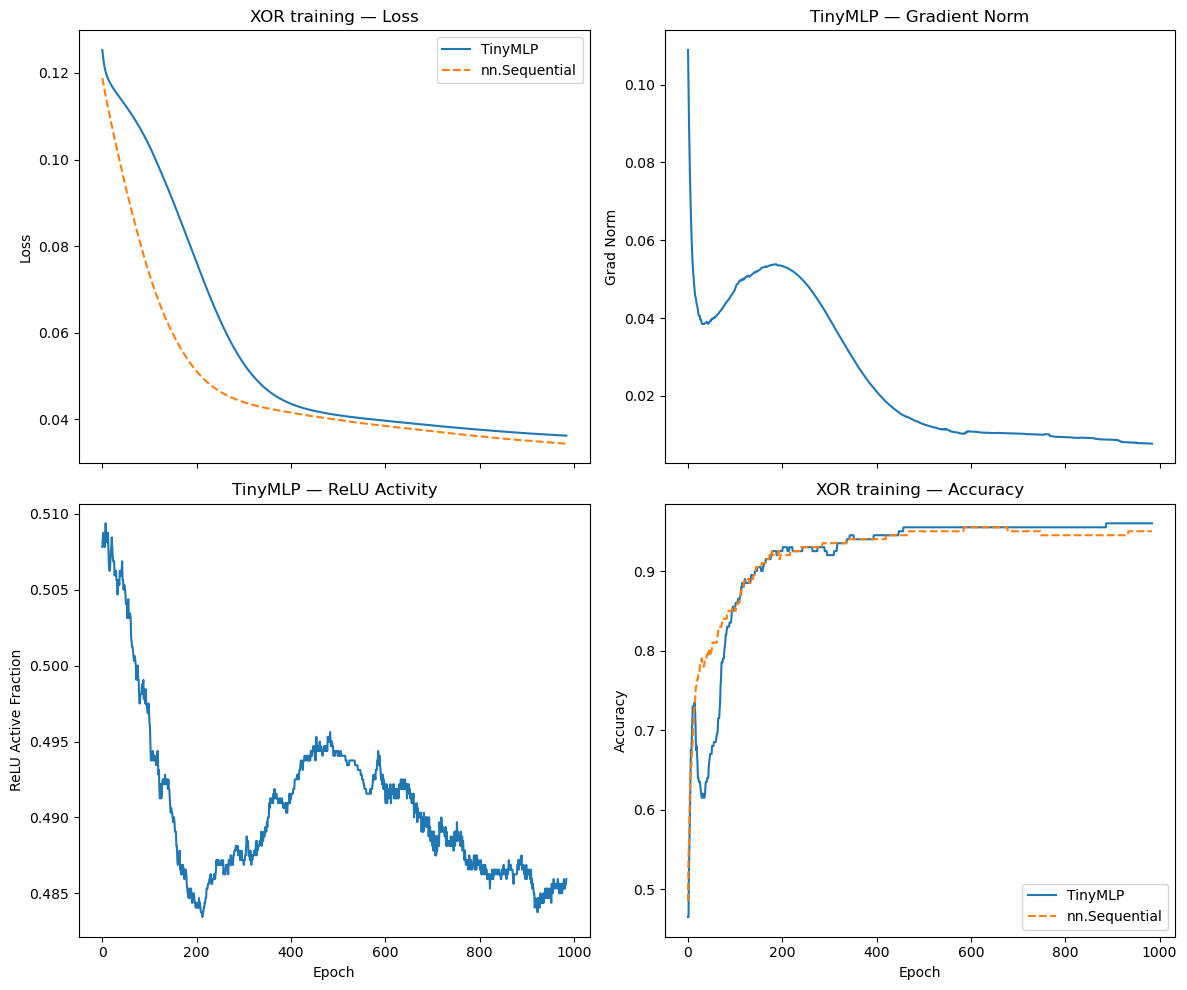

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

# -------------------- (0,0) Loss --------------------
axes[0, 0].plot(losses[15:], label="TinyMLP")
axes[0, 0].plot(seq_losses[15:], linestyle="--", label="nn.Sequential")
axes[0, 0].set_title("XOR training — Loss")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

# -------------------- (0,1) Gradient norm (TinyMLP) --------------------
axes[0, 1].plot(grad_norms[15:])
axes[0, 1].set_title("TinyMLP — Gradient Norm")
axes[0, 1].set_ylabel("Grad Norm")

# -------------------- (1,0) ReLU activity (TinyMLP) --------------------
axes[1, 0].plot(relu_activity[15:])
axes[1, 0].set_title("TinyMLP — ReLU Activity")
axes[1, 0].set_ylabel("ReLU Active Fraction")
axes[1, 0].set_xlabel("Epoch")

# -------------------- (1,1) Accuracy (TinyMLP vs Sequential) --------------------
axes[1, 1].plot(accuracies[15:], label="TinyMLP")
axes[1, 1].plot(seq_accuracies[15:], linestyle="--", label="nn.Sequential")
axes[1, 1].set_title("XOR training — Accuracy")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


<b><u><span style="font-size:18px">Decision Boundary</span></u></b>

***Observations and decision boundary***

The learned decision rule of the tiny MLP plot can be observed in two complementary ways:

**Left plot – Model output surface (soft view)**  
This shows the continuous output \( f(x) \in [0,1] \) over the grid.

- Yellow = high values (network thinks class = 1)  
- Purple = low values (class = 0)  
- The colours change smoothly because the MLP is a continuous function.  
- This view shows how the network “bends” the input space and how strongly it believes in each region.

**Right plot – Hard decision boundary**  
Here only the contour is plotted where \( f(x) = 0.5 \).  
This is the classification boundary: everything above is class 1 and below is class 0. 

In [50]:
def plot_decision_boundary_pair(
    f,
    X_train_np,
    y_train_np,
    title_prefix="Model (XOR)"
):
    """
    Plot two charts side by side for a given model f:

    - Left: continuous model output f(x) over 2D plane (contourf + training points)
    - Right: hard decision regions (f(x) >= 0.5 vs < 0.5) + training points

    Parameters
    ----------
    f : callable
        Function mapping a NumPy array of shape (N, 2) to a NumPy array of shape (N,)
        containing continuous outputs (e.g. probabilities or scores in [0,1]).
    X_train_np : np.ndarray, shape (N, 2)
        Training inputs.
    y_train_np : np.ndarray, shape (N,)
        Training labels (0 or 1).
    title_prefix : str
        Prefix for subplot titles.
    """

    # 1. Build a grid over [-1.2, 1.2]^2
    x_min, x_max = -1.2, 1.2
    y_min, y_max = -1.2, 1.2
    resolution = 200

    x1 = np.linspace(x_min, x_max, resolution)
    x2 = np.linspace(y_min, y_max, resolution)
    X1, X2 = np.meshgrid(x1, x2)
    grid = np.stack([X1.ravel(), X2.ravel()], axis=1)  # (resolution^2, 2)

    # 2. Evaluate model on the grid
    Z = f(grid)                         # shape (N_grid,)
    Z = Z.reshape(X1.shape)             # shape (resolution, resolution)

    # Hard classification: 0/1 after threshold 0.5
    Z_class = (Z >= 0.5).astype(float)

    X_train = X_train_np
    y_train = y_train_np

    # 3. Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ----- Left: continuous f(x) -----
    ax = axes[0]
    cs = ax.contourf(
        X1, X2, Z,
        levels=50,
        cmap="viridis",
        alpha=0.85,
    )
    plt.colorbar(cs, ax=ax, label="Model output f(x)")

    # overlay training points
    ax.scatter(
        X_train[y_train == 0, 0],
        X_train[y_train == 0, 1],
        c="white", edgecolor="black", marker="o", label="y=0"
    )
    ax.scatter(
        X_train[y_train == 1, 0],
        X_train[y_train == 1, 1],
        c="red", edgecolor="black", marker="^", label="y=1"
    )

    ax.set_title(f"{title_prefix}: continuous output")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc="upper right")

    # ----- Right: hard decision regions -----
    ax2 = axes[1]
    cs2 = ax2.contourf(
        X1, X2, Z_class,
        levels=[-0.5, 0.5, 1.5],  # 2 regions: <0.5 and >=0.5
        cmap="coolwarm",
        alpha=0.7,
    )
    plt.colorbar(cs2, ax=ax2, ticks=[0, 1], label="Predicted class")

    # overlay training points again
    ax2.scatter(
        X_train[y_train == 0, 0],
        X_train[y_train == 0, 1],
        c="white", edgecolor="black", marker="o", label="y=0"
    )
    ax2.scatter(
        X_train[y_train == 1, 0],
        X_train[y_train == 1, 1],
        c="red", edgecolor="black", marker="^", label="y=1"
    )

    ax2.set_title(f"{title_prefix}: decision regions (f(x) ≥ 0.5)")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# ----- Wrappers for each model type -----

def numpy_model_fn(X_batch_np: np.ndarray, params):
    """
    Evaluate the NumPy MLP with given params on a batch of inputs X_batch_np.
    Returns a 1D NumPy array of outputs (N,).
    """
    W1, b1, W2, b2 = params
    outputs = []
    for i in range(X_batch_np.shape[0]):
        # y is irrelevant for the forward output f, so we pass 0.0 as a dummy.
        _, f_i, _, _ = numpy_forward_single(
            X_batch_np[i], 0.0, W1, b1, W2, b2
        )
        outputs.append(f_i)
    return np.array(outputs)


def tinymlp_model_fn(X_batch_np: np.ndarray, model: TinyMLP, device=DEVICE):
    """
    Evaluate TinyMLP (nn.Module) on a NumPy batch.
    Returns a 1D NumPy array of outputs (N,).
    """
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_batch_np, dtype=torch.float32, device=device)
        F, _, _ = model(X_t)           # F: (N,)
        return F.cpu().numpy()


def sequential_model_fn(X_batch_np: np.ndarray, model_seq: nn.Sequential, device=DEVICE):
    """
    Evaluate nn.Sequential model on a NumPy batch.
    Returns a 1D NumPy array of outputs (N,).
    """
    model_seq.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_batch_np, dtype=torch.float32, device=device)
        F_seq = model_seq(X_t).squeeze(-1)   # (N,)
        return F_seq.cpu().numpy()

<b><u><span style="font-size:18px">Plot decision boundary for trained MLP</span></u></b>

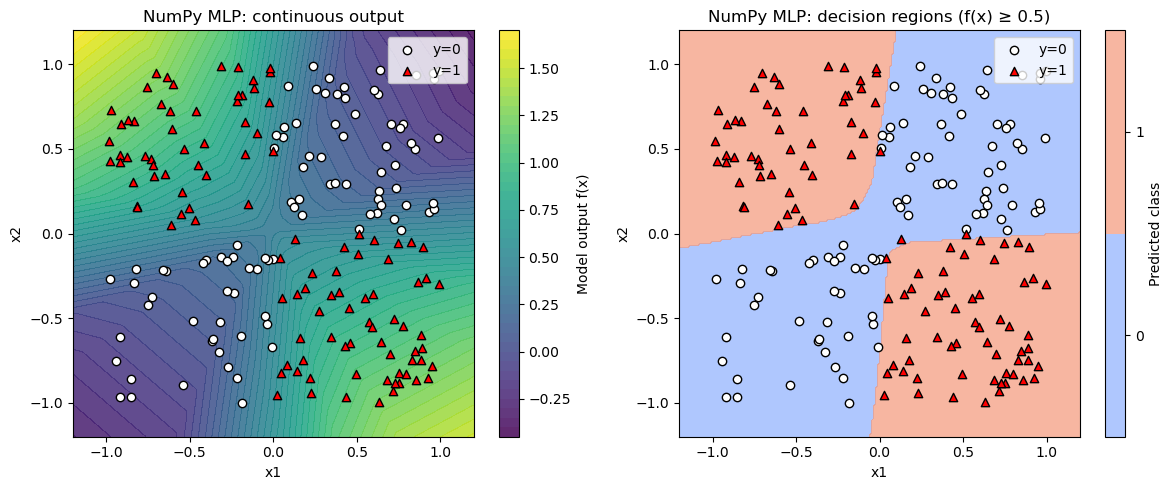

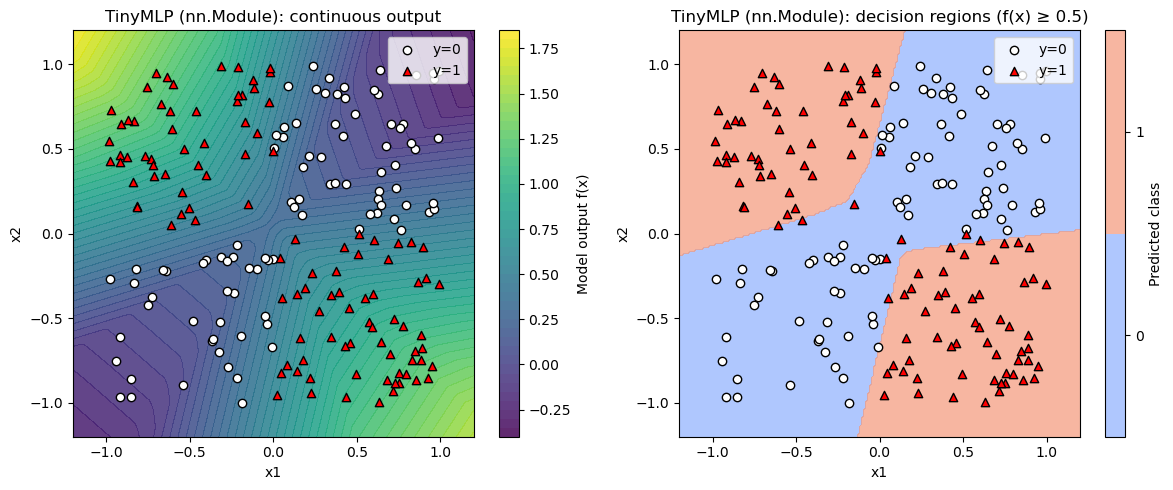

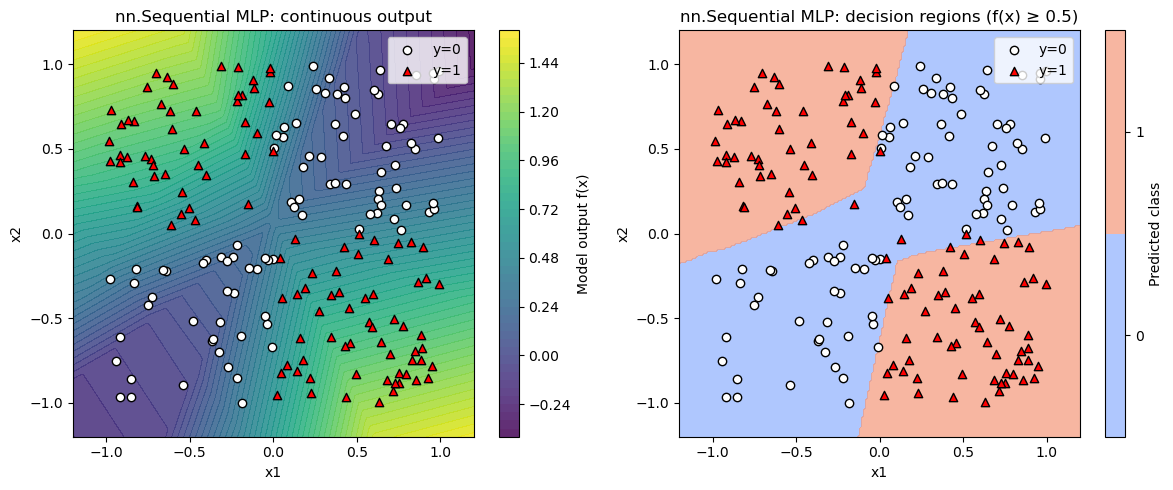

In [51]:
# NumPy model decision boundary
plot_decision_boundary_pair(
    lambda X: numpy_model_fn(X, params_np),
    X_train_np,
    y_train_np,
    title_prefix="NumPy MLP"
)

# TinyMLP (nn.Module) decision boundary
plot_decision_boundary_pair(
    lambda X: tinymlp_model_fn(X, tiny_mlp, device=DEVICE),
    X_train_np,
    y_train_np,
    title_prefix="TinyMLP (nn.Module)"
)

# nn.Sequential decision boundary
plot_decision_boundary_pair(
    lambda X: sequential_model_fn(X, model_seq, device=DEVICE),
    X_train_np,
    y_train_np,
    title_prefix="nn.Sequential MLP"
)